In [148]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import matplotlib.pyplot as plt
import random
import OpenEXR
import Imath

In [149]:
class EXRDataset(Dataset):
    def __init__(self, directory):
        self.directory = directory
        self.files = [f for f in os.listdir(directory) if f.endswith('.exr')]

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        file_path = os.path.join(self.directory, self.files[idx])
        
        # Load EXR image
        exr_file = OpenEXR.InputFile(file_path)
        dw = exr_file.header()['dataWindow']
        width = dw.max.x - dw.min.x + 1
        height = dw.max.y - dw.min.y + 1
        assert(width == 256 and height == 256)
        
        # Extract channels
        pt = Imath.PixelType(Imath.PixelType.FLOAT)
        input_channels = [np.frombuffer(exr_file.channel(c, pt), dtype=np.float32).reshape(height, width) for c in ['R', 'G']]
        target_channels = [np.frombuffer(exr_file.channel(c, pt), dtype=np.float32).reshape(height, width) for c in ['B', 'A']]
        
        # Stack channels
        input = np.stack(input_channels, axis=0)  # Shape: (2, H, W)
        target = np.stack(target_channels, axis=0)  # Shape: (2, H, W)

        # Convert to tensors
        input = torch.tensor(input, dtype=torch.float32) # Shape: (2, H, W)
        target = torch.tensor(target, dtype=torch.float32)  # Shape: (2, H, W)
        
        
        return input, target, idx
    

def parse_filename(filename):
    filename = filename[0:-4]
    parts = filename.split('_')
    seed = parts[1]
    wave = parts[3]
    height = float(parts[5])
    return seed, wave, height


def load_dataset(batch_size):
    #  get local path
    local_path = os.getcwd()
    dataset = EXRDataset(local_path + "/data_noise_a/")
    
    # Split dataset into train and validation
    train_size = int(0.6 * len(dataset))
    val_size = int(0.2 * len(dataset))
    test_size = len(dataset) - train_size - val_size

    train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])
    
    # Create DataLoader
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # Print dataset sizes
    print(f"Train size: {len(train_dataset)}")
    print(f"Validation size: {len(val_dataset)}")
    print(f"Test size: {len(test_dataset)}")
    
    return train_loader, val_loader, test_loader


def verify_dataset():
    batch_size = 256
    tr_loader, va_loader, te_loader = load_dataset(batch_size)
    tr_inputs, tr_targets, idxs = next(iter(tr_loader))

    # Get the first image in the batch
    input = tr_inputs[0].squeeze(0).numpy()  # Shape: (2, H, W)
    target = tr_targets[0].squeeze(0).numpy()  # Shape: (2, H, W)
    
    dataset = tr_loader.dataset.dataset

    filename = dataset.files[idxs[0]]
    seed, wave, height = parse_filename(filename)
    

    # Plot the full input and target images
    fig, axs = plt.subplots(2, 2, figsize=(12, 12))
    axs[0, 0].imshow(input[0], cmap='Blues')
    axs[0, 0].set_title(f'Input Wave - {seed} - {wave}')
    axs[0, 1].imshow(input[1], cmap='gray')
    axs[0, 1].set_title(f'Input Terrain - {seed} - {wave}')
    axs[1, 0].imshow(target[0], cmap='Blues')
    axs[1, 0].set_title(f'Target Depth - {seed} - {wave}')
    axs[1, 1].imshow(target[1], cmap='gray')
    axs[1, 1].set_title(f'Target Terrain - {seed} - {wave}')
    plt.show()



In [150]:
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()

        # Encoder: Downsampling Path
        self.enc1 = self.conv_block(2, 16)
        self.enc2 = self.conv_block(16, 32)
        self.enc3 = self.conv_block(32, 64)
        self.enc4 = self.conv_block(64, 128)

        # Bottleneck
        self.bottleneck = self.conv_block(128, 256)

        # Decoder: Upsampling Path
        self.up4 = self.upconv_block(256, 128)
        self.dec4 = self.conv_block(256, 128)

        self.up3 = self.upconv_block(128, 64)
        self.dec3 = self.conv_block(128, 64)

        self.up2 = self.upconv_block(64, 32)
        self.dec2 = self.conv_block(64, 32)

        self.up1 = self.upconv_block(32, 16)
        self.dec1 = self.conv_block(32, 16)

        # Final Output Layer
        self.final = nn.Conv2d(16, 2, kernel_size=1)

    def conv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def upconv_block(self, in_channels, out_channels):
        return nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)

    def forward(self, x):
        # Encoder
        enc1 = self.enc1(x)                                    # Output: (batch_size, 16, 256, 256)
        enc2 = self.enc2(nn.MaxPool2d(2)(enc1))                # Output: (batch_size, 32, 128, 128)
        enc3 = self.enc3(nn.MaxPool2d(2)(enc2))                # Output: (batch_size, 64, 64, 64)
        enc4 = self.enc4(nn.MaxPool2d(2)(enc3))                # Output: (batch_size, 128, 32, 32)

        # Bottleneck
        bottleneck = self.bottleneck(nn.MaxPool2d(2)(enc4))    # Output: (batch_size, 256, 16, 16)

        # Decoder with Skip Connections
        up4 = self.up4(bottleneck)                             # Output: (batch_size, 128, 32, 32)
        dec4 = self.dec4(torch.cat((up4, enc4), dim=1))        # Concatenate along channels

        up3 = self.up3(dec4)                                   # Output: (batch_size, 64, 64, 64)
        dec3 = self.dec3(torch.cat((up3, enc3), dim=1))        # Concatenate along channels

        up2 = self.up2(dec3)                                   # Output: (batch_size, 32, 128, 128)
        dec2 = self.dec2(torch.cat((up2, enc2), dim=1))        # Concatenate along channels

        up1 = self.up1(dec2)                                   # Output: (batch_size, 16, 256, 256)
        dec1 = self.dec1(torch.cat((up1, enc1), dim=1))        # Concatenate along channels

        # Final Layer
        output = self.final(dec1)                              # Output: (batch_size, 2, 256, 256)
        return output


In [151]:
def evaluate_model(device, model, loader, criterion):
    model.eval()  # Set model to evaluation mode
    val_loss = 0.0
    val_acc = 0.0
    with torch.no_grad():  # No gradients needed
        for inputs, targets, idx in loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)

            val_acc = torch.sum(torch.abs(outputs - targets))

            loss = criterion(outputs, targets)
            
            val_loss += loss.item()
    
    val_loss = val_loss / len(loader)
    val_acc /= (len(loader) * (256 * 256 * 2))
    return val_loss, val_acc


def train_model(device, model, train_loader, val_loader, criterion, optimizer, n_epochs):
    #  output lists
    all_train_loss = []
    all_train_accuracy = []
    all_val_loss = []
    all_val_accuracy = []

    for epoch in range(n_epochs):
        #  reset each epoch
        train_loss = 0.0
        train_accuracy = 0.0
        sum_diff = 0.0

        for inputs, targets, idx in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)

            # Forward pass
            model.train()
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            # Calculate accuracy
            sum_diff = torch.sum(torch.abs(outputs - targets))
            
            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        train_accuracy = sum_diff / (len(train_loader) * (256 * 256 * 2))
        
        # print(f'Should have criterion here? {criterion}')
        all_train_loss.append(train_loss/len(train_loader))
        all_train_accuracy.append(train_accuracy)
        # Validation loss
        val_loss, val_acc = evaluate_model(device, model, val_loader, criterion)
        all_val_loss.append(val_loss)
        all_val_accuracy.append(val_acc)

        print(f'Epoch {epoch+1}/{n_epochs}\n\t - Training Loss: {train_loss/len(train_loader)} | Training Accuracy: {train_accuracy}\n\t - Validation Loss: {val_loss} | Validation Accuracy: {val_acc}')




Train size: 300
Validation size: 100
Test size: 100
Using device: cuda
Epoch 1/10
	 - Training Loss: 0.0659692695364356 | Training Accuracy: 0.10361887514591217
	 - Validation Loss: 266206464.0 | Validation Accuracy: 12014.939453125
Epoch 2/10
	 - Training Loss: 0.010185573482885957 | Training Accuracy: 0.0754101350903511
	 - Validation Loss: 469.1460189819336 | Validation Accuracy: 13.174910545349121
Epoch 3/10
	 - Training Loss: 0.006354397442191839 | Training Accuracy: 0.061756473034620285
	 - Validation Loss: 0.283977672457695 | Validation Accuracy: 0.2496853768825531
Epoch 4/10
	 - Training Loss: 0.0035680007422342896 | Training Accuracy: 0.04718399792909622
	 - Validation Loss: 0.005519134574569762 | Validation Accuracy: 0.04893103986978531
Epoch 5/10
	 - Training Loss: 0.002607331983745098 | Training Accuracy: 0.03732795640826225
	 - Validation Loss: 0.002735369373112917 | Validation Accuracy: 0.04060208052396774
Epoch 6/10
	 - Training Loss: 0.00207225289195776 | Training Accur

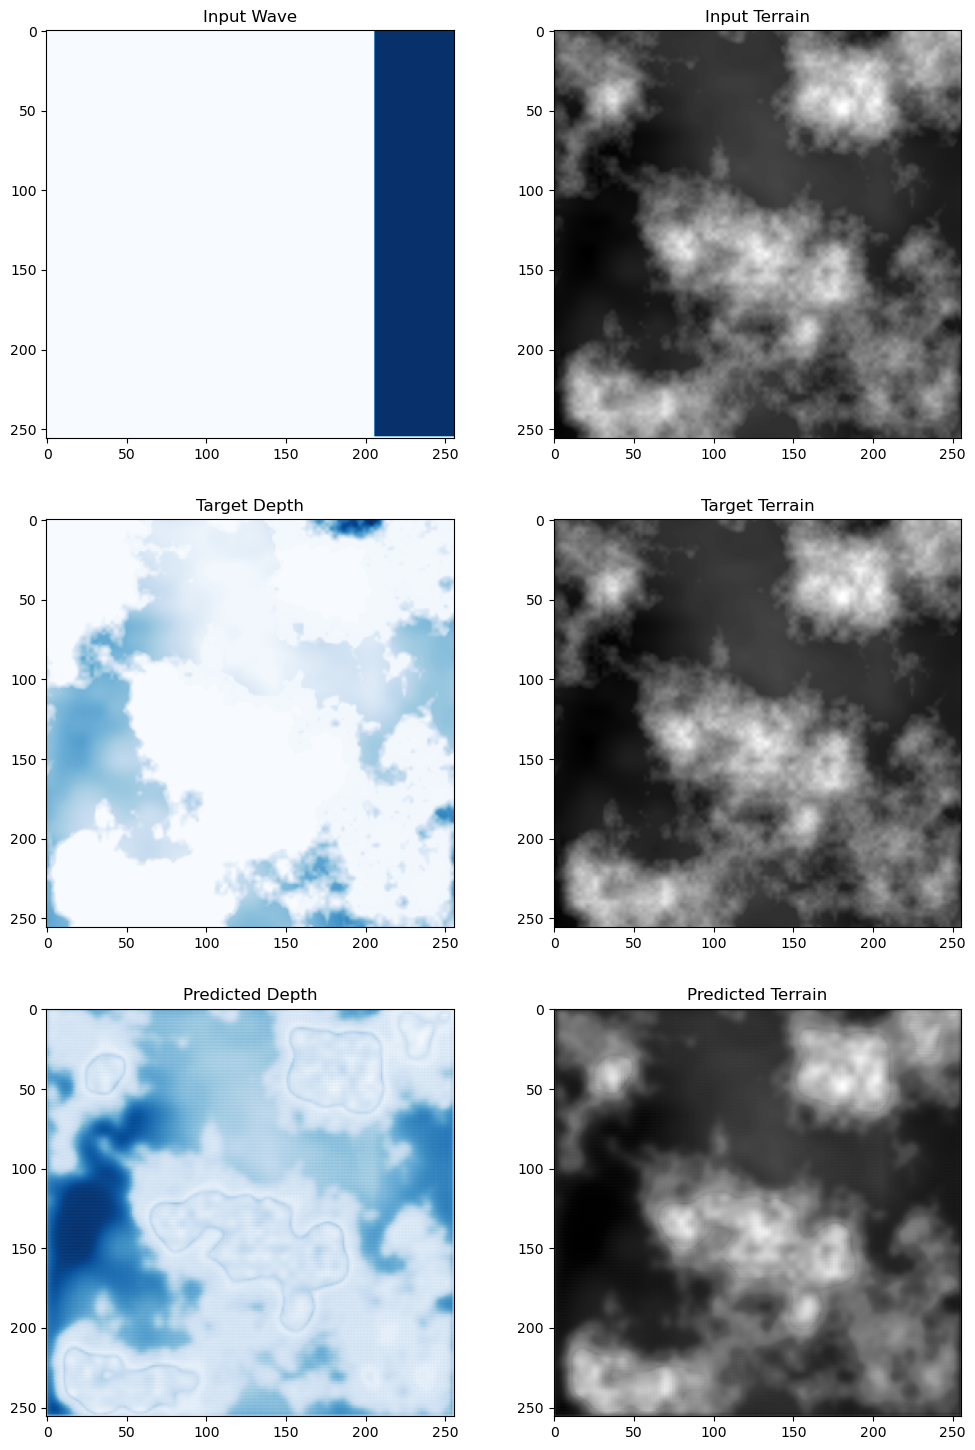

In [ ]:
#  expand on this to select randomly and include seed/wave type
def plot_actual_vs_predicted(device, model, loader):
    model.eval()  # Set model to evaluation mode
    with torch.no_grad():  # No gradients needed
        try:
            inputs, targets, idx = next(iter(loader))
        except StopIteration:
            print("Loader is empty. Cannot plot actual vs predicted.")
            return
        
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        
        # Get the first image in the batch
        input = inputs[0].squeeze(0).cpu().numpy()  # Shape: (2, H, W)
        target = targets[0].squeeze(0).cpu().numpy()  # Shape: (2, H, W)
        output = outputs[0].squeeze(0).cpu().numpy()  # Shape: (2, H, W)
        
        # Plot the full input, target, and output images
        fig, axs = plt.subplots(3, 2, figsize=(12, 18))
        axs[0, 0].imshow(input[0], cmap='Blues')
        axs[0, 0].set_title('Input Wave')
        axs[0, 1].imshow(input[1], cmap='gray')
        axs[0, 1].set_title('Input Terrain')
        axs[1, 0].imshow(target[0], cmap='Blues')
        axs[1, 0].set_title('Target Depth')
        axs[1, 1].imshow(target[1], cmap='gray')
        axs[1, 1].set_title('Target Terrain')
        axs[2, 0].imshow(output[0], cmap='Blues')
        axs[2, 0].set_title('Predicted Depth')
        axs[2, 1].imshow(output[1], cmap='gray')
        axs[2, 1].set_title('Predicted Terrain')
        plt.show()

def experiment(batch_size, n_epochs, learning_rate):
    # Load dataset
    train_loader, val_loader, test_loader = load_dataset(batch_size)
    
    # Initialize model
    model = UNet()
    
    # Set device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f'Using device: {device}')
    model.to(device)
    
    # Loss function and optimizer
    criterion = nn.MSELoss()
    optimizer = optim.AdamW(model.parameters(), lr=learning_rate)
    
    # Train model
    train_model(device, model, train_loader, val_loader, criterion, optimizer, n_epochs)
    
    # Evaluate model
    test_loss, test_acc = evaluate_model(device, model, test_loader, criterion)
    print(f'Test Loss: {test_loss:.25f}')

    # Plot actual vs predicted
    plot_actual_vs_predicted(device, model, test_loader)



experiment(batch_size=32, n_epochs=25, learning_rate=0.002)